## import necessary libraries

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm import tqdm

## set environment

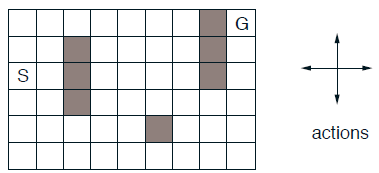

In [85]:
'''our environment is a grid world with some walls inside it
agent starts at S point, has 4 possible actions and its gial is to reach to G point
position of agent will be determined by a list that first element is row number 
and secound element is column number
(0,0) | (0,1) ... 
(1,0) | (1,1)
(2,0) | (2,1)
.
.
.
'''
class simple_maze():
    
    def __init__(self):
        # determine boundaries of grid world
        self.min_rows=0
        self.max_rows=5
        self.min_cols=0
        self.max_cols=8
        # start point
        self.S=(2,0)
        # goal point
        self.G=(0,8)
        # walls position
        self.walls=[]
        for row in range(0,3):
            self.walls.append((row,7))
            
        for row in range(1,4):
            self.walls.append((row,2))
        self.walls.append((4,5))
        
    # reset method of env returns start state
    def reset(self):
        
        return self.S
    
    # step methos that takes current state and action and returns next state
    def step(self,state,action):
        # state[0]= row state[1]=column
        if action==0: # right 
            next_state=(state[0],min(state[1]+1,self.max_cols))
            # check for walls 
            if next_state in self.walls:
                next_state=state
                
        if action==1: #down
            next_state=(min(state[0]+1,self.max_rows),state[1])
            # check for walls 
            if next_state in self.walls:
                next_state=state
        
        if action==2: # left
            next_state=(state[0],max(state[1]-1,self.min_cols))
            # check for walls 
            if next_state in self.walls:
                next_state=state
        
        if action==3: # up
            next_state=(max(state[0]-1,self.min_rows),state[1])
            # check for walls 
            if next_state in self.walls:
                next_state=state
        # check for Goal state
        if next_state==self.G:
            reward=1
            done=True
        else:
            reward=0
            done=False
        
        return next_state,reward,done
     
        
env=simple_maze()
# test : expected output : ([2, 1], 0, False)
env.step((0,1),2)

((0, 0), 0, False)

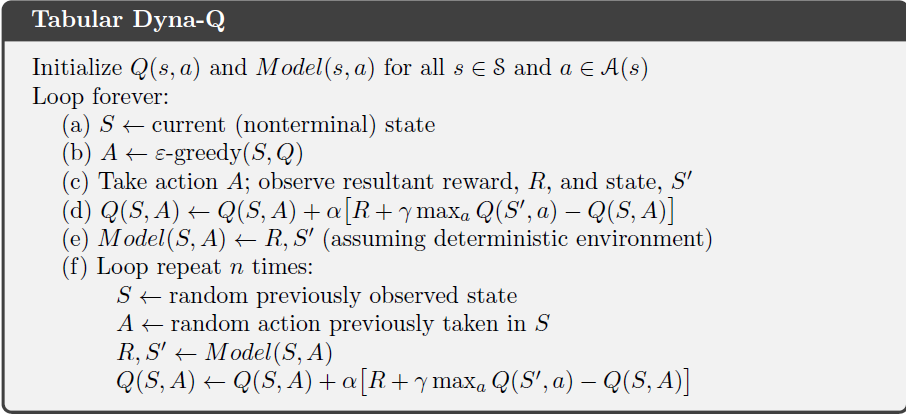

In [166]:
class tabular_dyna_q():
    def __init__(self,env,epsilon,step_size,discount_factor,num_planning):
        
        self.DF=discount_factor
        self.step_size=step_size
        self.n_planning=num_planning
        self.epsilon=epsilon
        self.env=env
        self.model=defaultdict(float)
        self.Q=defaultdict(float)
    
    # EPSILON GREEDY POLICY
    def e_greedy(self,state):

        # exploration
        if self.epsilon>np.random.rand(1)[0]:
            return np.random.choice(range(0,4))
        
        # exploitaion
        else:
            q=[]
            for action in range(0,4):
                q.append(self.Q[(state,action)])
            return np.argmax(q)
        
    def trainer(self,num_episodes,max_step_per_episode):
 
        steps_per_episode=[]
        for episode in tqdm(range(num_episodes)):
           # initialize recorders 
            observed_states=[]
            taken_actions={}            
            done = False
            step_counter=0
            state=self.env.reset()
            observed_states.append(state)
            action=self.e_greedy(state)
            taken_actions[f'{state}']=[action]

            while done==False and step_counter<=max_step_per_episode: 
                step_counter+=1
                # take action 
                next_state,reward,done=self.env.step(state,action)
                # calculate next action according to next state
                nex_action=self.e_greedy(next_state)
                # save observed state
                observed_states.append(next_state)
                # save taken actions in next state
                if f'{next_state}' not in taken_actions.keys():
                    taken_actions[f'{next_state}']=[nex_action]
                else:
                    taken_actions[f'{next_state}'].append(nex_action)
                    taken_actions[f'{next_state}']=list(np.unique(taken_actions[f'{next_state}']))
                # update action state value function
                self.Q[(state,action)]+=self.step_size*(reward\
                    +self.DF*max([self.Q[(next_state,a)] for a in range(0,4)])-self.Q[(state,action)])
                # save experiences to a tabular model
                self.model[(state,action)]=[next_state,reward]
                state=next_state
                action=nex_action
                # PLANNING PHASE BEGINS AFTER FIRST EPISODE
                if episode>0:
                    for step in range(self.n_planning):
                        idx_S=np.random.choice(range(0,len(set(observed_states))))
                        S=list(set(observed_states))[idx_S]
                        A=np.random.choice(np.unique(taken_actions[f'{S}']))
                        '''we define a variable named 'flag' ti indicate if 
                         selected action have taken in sselected state or not 
                         if flag be equal to True means it is.'''
                        # model return a list that list[0]=S` and list[1]=R
                        flag=True
                        if self.model[(S,A)]==0.0:
                                flag= False

                        # update is state isn't terminal state and flag is True             
                        if S !=(0,8) and flag:
                            
                            next_S=self.model[(S,A)][0]
                            
                            R=self.model[(S,A)][1] 
                            #print(S,'----',A,'-----',next_S,'--------',R)
                            self.Q[(S,A)]+=self.step_size*(R\
                            +self.DF*max([self.Q[(next_S,a)] for a in range(0,4)])-self.Q[(S,A)])

                
            steps_per_episode.append(step_counter)

        return steps_per_episode,self.Q
    


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 13.63it/s]


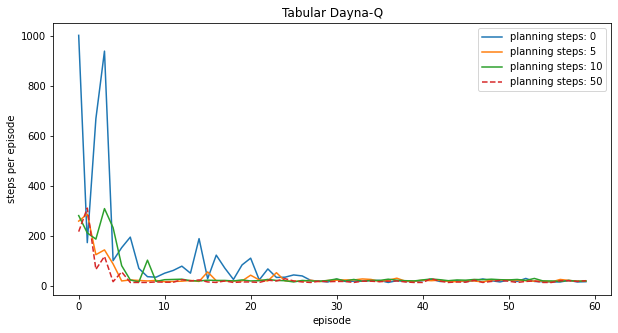

In [204]:
def runner(n_list):
    linestyles=['--','solid']
    plt.figure(figsize=(10,5))
    for n in n_list:
        dyna_q=tabular_dyna_q(env,0.2,0.2,1,n)
        result,Q_function=dyna_q.trainer(num_episodes=60,max_step_per_episode=1000)
        plt.plot(result,label=f'planning steps: {n}',
                               linestyle='solid' if n==0 or n==5 or n==10 else '--')
    plt.legend()
    plt.title('Tabular Dyna-Q')
    plt.xlabel('episode')
    plt.ylabel('steps per episode')
    plt.savefig('Dyna-Q result')
    plt.show()
    return Q_function
Q_function=runner([0,5,10,50])
        
    

## plot optimal path

In [185]:
def path(q_function):
    
    path=np.zeros(shape=(6,9))
    initial_state=env.reset()
    path[initial_state[0],initial_state[1]]=1
    done=False
    while done ==False:
        next_action=np.argmax([q_function[(initial_state,a)] for a in range(0,4)])
        next_state,r,done=env.step(initial_state,next_action)
        path[next_state[0],next_state[1]]=1
        initial_state=next_state
        
        
    return path

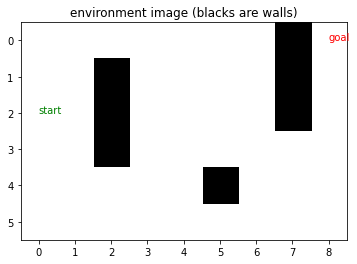

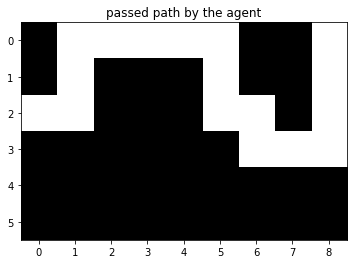

In [203]:
raw_path=np.ones(shape=(6,9))
for wall in env.walls:
    raw_path[wall[0],wall[1]]=0
plt.title('environment image (blacks are walls)')
plt.annotate(text='start',xy=(0,2),c='green')
plt.annotate(text='goal',xy=(8,0),c='red')
plt.imshow(raw_path,cmap='gray')
plt.savefig('environment')
plt.show()   
path_=path(Q_function)
plt.imshow(path_,cmap='gray')
plt.title('passed path by the agent')
plt.savefig('passed path by the agent')
plt.show()


[(0, 7), (1, 7), (2, 7), (1, 2), (2, 2), (3, 2), (4, 5)]